# Capstone project Function 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
import ast
from scipy.stats import norm
from numpy.linalg import norm as linalg_norm

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Description of function

Imagine a black box, or a mystery ML model, that takes two numbers as input and returns a log-likelihood score. Your goal is to maximise that score, but each output is noisy, and depending on where you start, you might get stuck in a local optimum. 

To tackle this, you use Bayesian optimisation, which selects the next inputs based on what it has learned so far. It balances exploration with exploitation, making it well suited to noisy outputs and complex functions with many local peaks.


Function is inputs 2D array (10,2), outputs 1D array (10,1)

### Step 1: Load in data and visualise

In [12]:
inputdata = np.load('Initial_inputs.npy')
outputdata = np.load('Initial_outputs.npy')

X = inputdata
y = outputdata
print(X)
print(y)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522]


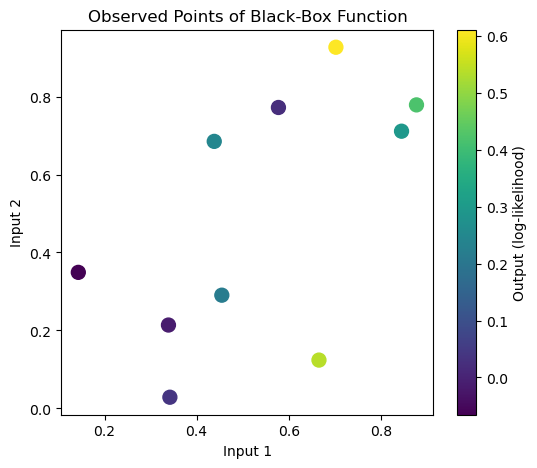

In [8]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=100)
plt.colorbar(label='Output (log-likelihood)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Observed Points of Black-Box Function')
plt.show()


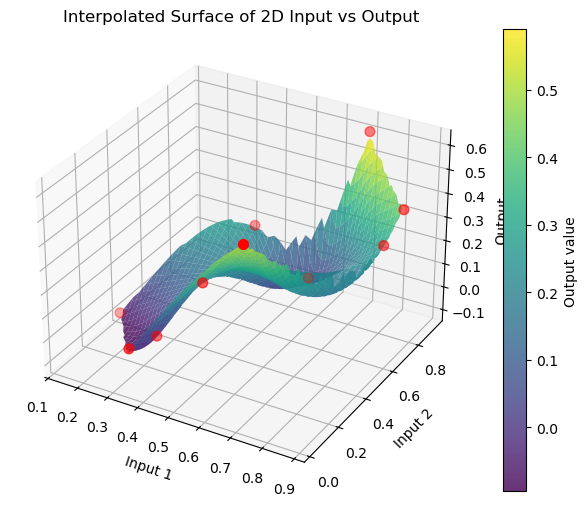

In [10]:
x1 = X[:,0]
x2 = X[:,1]

# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output')
fig.colorbar(surf, label='Output value')
plt.show()

### Step 2: Fit a surrogate model to the data - in this case a GP

In [12]:
kernel = Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, random_state=42)

### Step 3: Create a 2D grid to visualise the surrogate

In [13]:
# Create 2D grid to visualize surrogate
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

### Step 4: Plot the GP prediction from the model

In [15]:
mu, sigma = gp.predict(X_grid, return_std = True)

### Step 5: Apply the acquisition function

In [16]:
kappa = 3  # exploration-exploitation, this time round going for more exploration
UCB = mu + kappa*sigma

### Step 6: Look for next point

In [17]:
next_idx = np.argmax(UCB)
x_next = X_grid[next_idx]
print("Next coordinate to explore (UCB):", x_next)

Next coordinate to explore (UCB): [1. 0.]


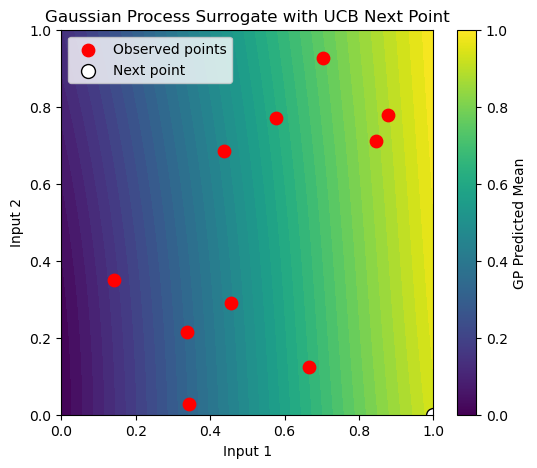

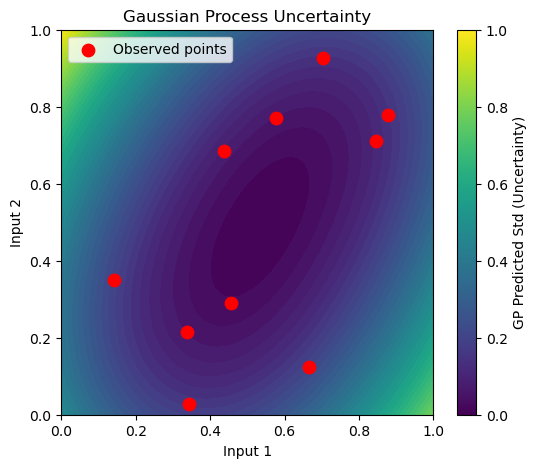

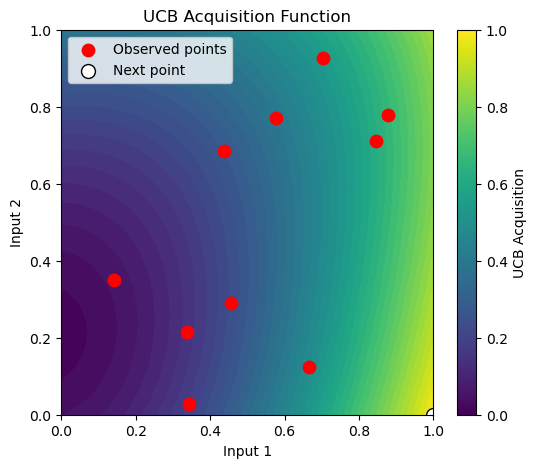

In [18]:
# -------------------------
# 7. Visualize GP mean
# -------------------------
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, mu.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='red', s=80, label='Observed points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.colorbar(label='GP Predicted Mean')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Gaussian Process Surrogate with UCB Next Point')
plt.legend()
plt.show()

# -------------------------
# 8. Visualize GP uncertainty
# -------------------------
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, sigma.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='red', s=80, label='Observed points')
plt.colorbar(label='GP Predicted Std (Uncertainty)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Gaussian Process Uncertainty')
plt.legend()
plt.show()

# -------------------------
# 9. Visualize UCB acquisition
# -------------------------
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='red', s=80, label='Observed points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.colorbar(label='UCB Acquisition')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('UCB Acquisition Function')
plt.legend()
plt.show()

# ****** Week 2 data update and optimisation *********

## Step 1: Load in new data from first optimisation

In [3]:
inputdata = np.load('Initial_inputs.npy')
outputdata = np.load('Initial_outputs.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Inputs_Outputs/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week2 = inputs_week2[1]
F1_outputs_week2 = outputs_week2[1]


# Step 5: merge with previous data
F1_inputs_week2 = F1_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F1_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F1_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

#Save results
np.save('inputs_week2.npy',inputdata_week2)
np.save('outputs_week2.npy', outputdata_week2)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849]


### Step 2: Review new information 

In [7]:
X_wk2 = inputdata_week2
y_wk2 = outputdata_week2

#Comparison between week1 
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=100)
plt.colorbar(label='Output (log-likelihood)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Observed Points of Black-Box Function-Week1')
plt.show()

#week 2
plt.figure(figsize=(6,5))
plt.scatter(X_wk2[:,0], X_wk2[:,1], c=y_wk2, cmap='viridis', s=100)
plt.colorbar(label='Output (log-likelihood)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Observed Points of Black-Box Function-Week2')
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Week 1 ---
sc1 = axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=100)
axes[0].set_xlabel('Input 1')
axes[0].set_ylabel('Input 2')
axes[0].set_title('Observed Points of Black-Box Function - Week 1')
fig.colorbar(sc1, ax=axes[0], label='Output (log-likelihood)')

# --- Week 2 ---
sc2 = axes[1].scatter(X_wk2[:, 0], X_wk2[:, 1], c=y_wk2, cmap='viridis', s=100)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].set_title('Observed Points of Black-Box Function - Week 2')
fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')

plt.tight_layout()
plt.show()


NameError: name 'X' is not defined

<Figure size 600x500 with 0 Axes>

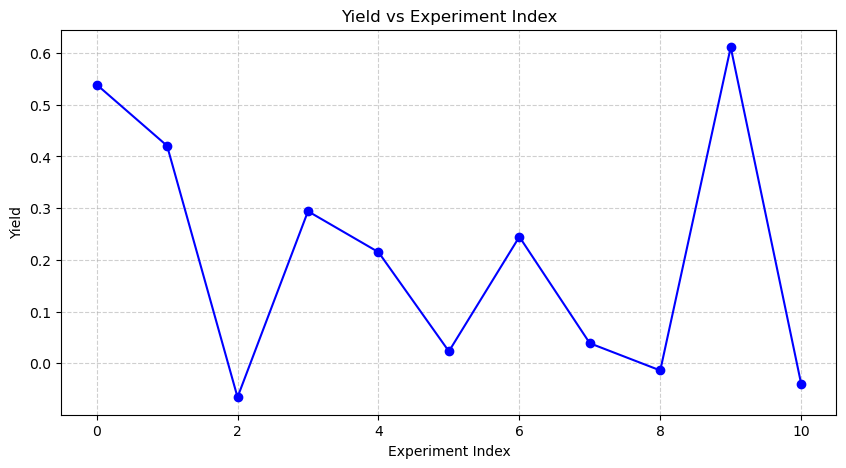

Best parameters: [0.70263656 0.9265642 ]
Best yield: 0.6112052157614438


In [8]:
indices = np.arange(len(outputdata_week2))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week2, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week2)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Step 3 - fit the new surrogate model

In [14]:
kernel = Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_wk2, y_wk2)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, random_state=42)

In [15]:
# Create 2D grid to visualize surrogate
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

mu, sigma = gp.predict(X_grid, return_std = True)

### Step 4: Apply acquisition function

In [16]:
kappa = 3  # exploration-exploitation, this time round going for more exploration
UCB = mu + kappa*sigma

### Step 5: Look for next point based on UCB

In [17]:
next_idx = np.argmax(UCB)
x_next = X_grid[next_idx]
print("Next coordinate to explore (UCB):", x_next)

Next coordinate to explore (UCB): [1. 1.]


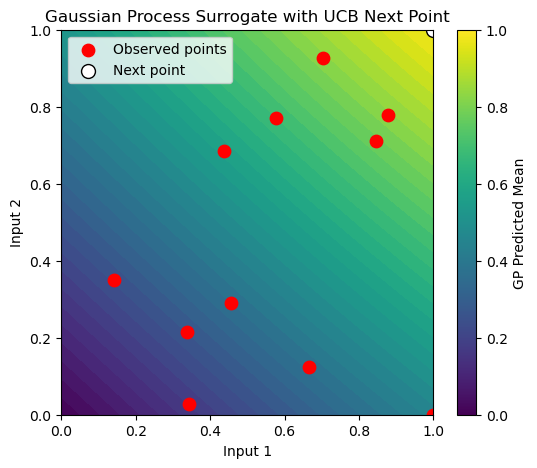

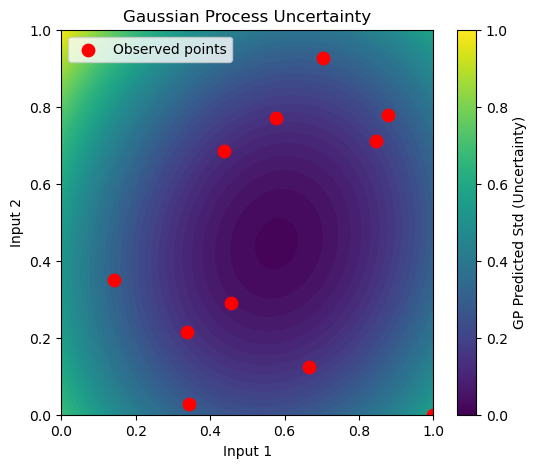

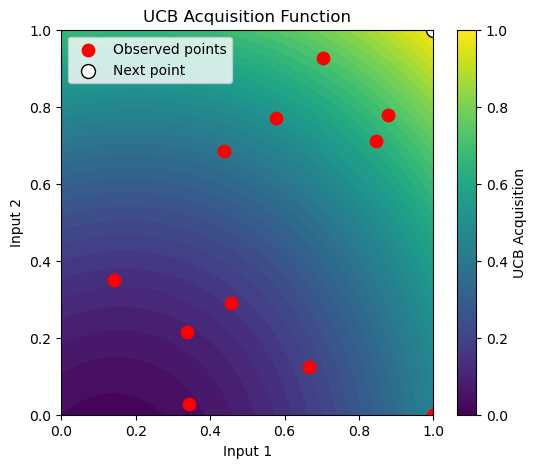

In [19]:
# -------------------------
# 7. Visualize GP mean
# -------------------------
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, mu.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X_wk2[:,0], X_wk2[:,1], c='red', s=80, label='Observed points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.colorbar(label='GP Predicted Mean')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Gaussian Process Surrogate with UCB Next Point')
plt.legend()
plt.show()

# -------------------------
# 8. Visualize GP uncertainty
# -------------------------
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, sigma.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X_wk2[:,0], X_wk2[:,1], c='red', s=80, label='Observed points')
plt.colorbar(label='GP Predicted Std (Uncertainty)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Gaussian Process Uncertainty')
plt.legend()
plt.show()

# -------------------------
# 9. Visualize UCB acquisition
# -------------------------
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X_wk2[:,0], X_wk2[:,1], c='red', s=80, label='Observed points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.colorbar(label='UCB Acquisition')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('UCB Acquisition Function')
plt.legend()
plt.show()

## ***** Week 3: Update data for function ptimisation ******

### Step 1: Load in the result from week two tuning option and concatenate to original array

In [4]:
#Load in original input and output data 
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week3 = inputs_week3[1]
F1_outputs_week3 = outputs_week3[1]


# Step 5: merge with previous data
F1_inputs_week3 = F1_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F1_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F1_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

# Save the results of these
np.save('inputs_week3.npy',inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]
 [1.         1.        ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849 -0.1539788 ]


### Step 2: Visualise the results 

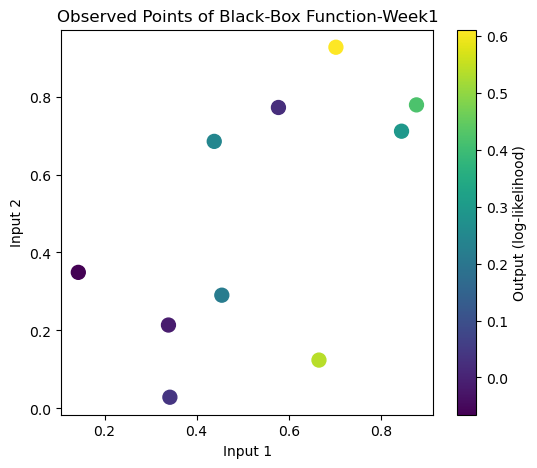

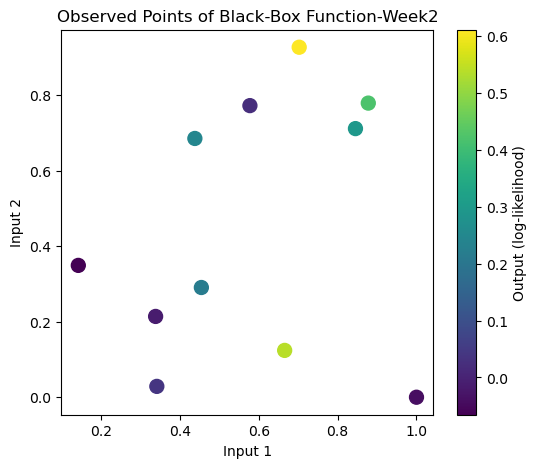

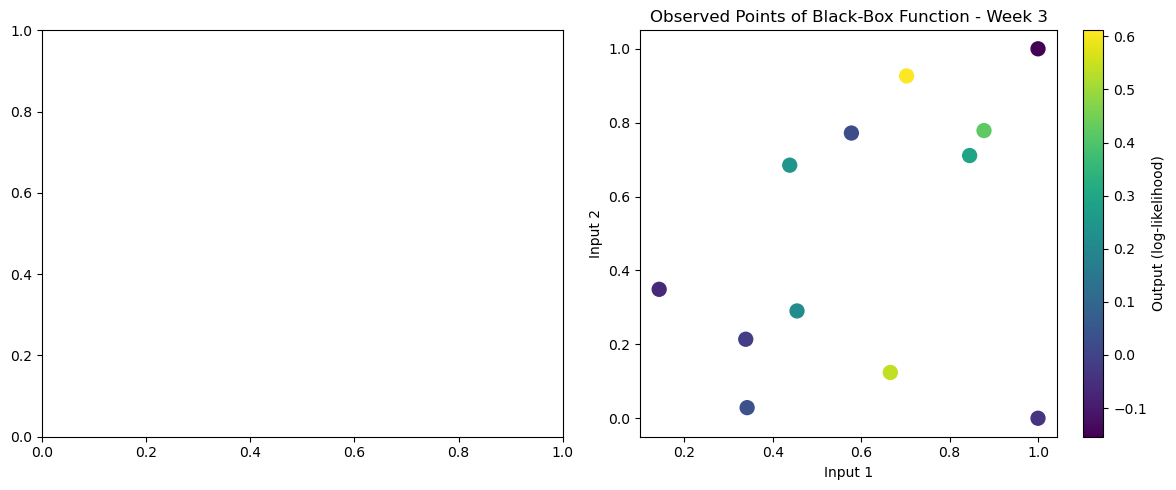

In [16]:
X_wk3 = inputdata_week3
y_wk3 = outputdata_week3

#Comparison between week1 
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=100)
plt.colorbar(label='Output (log-likelihood)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Observed Points of Black-Box Function-Week1')
plt.show()

#week 2
plt.figure(figsize=(6,5))
plt.scatter(X_wk2[:,0], X_wk2[:,1], c=y_wk2, cmap='viridis', s=100)
plt.colorbar(label='Output (log-likelihood)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Observed Points of Black-Box Function-Week2')
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Week 3 ---
sc2 = axes[1].scatter(X_wk3[:, 0], X_wk3[:, 1], c=y_wk3, cmap='viridis', s=100)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].set_title('Observed Points of Black-Box Function - Week 3')
fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')



plt.tight_layout()
plt.show()

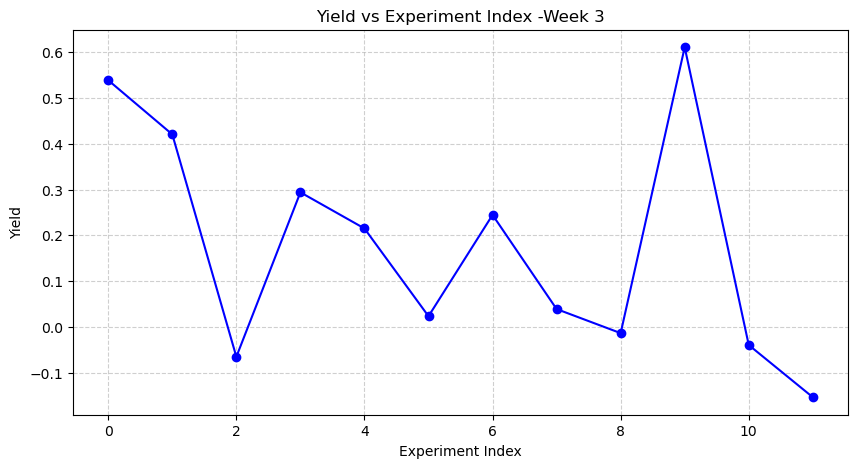

Best parameters: [0.70263656 0.9265642 ]
Best yield: 0.6112052157614438


In [17]:
indices = np.arange(len(outputdata_week3))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week3, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 3')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week3)
best_x = inputdata_week3[best_idx]
best_y = outputdata_week3[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Step 3: Update surrogate model -GP

In [25]:
print(X_wk3, y_wk3)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]
 [1.         1.        ]] [ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849 -0.1539788 ]


In [39]:
kernel = Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_wk3, y_wk3)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, random_state=42)

In [46]:
# Create 2D grid to visualize surrogate
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_candidate = np.column_stack([X1.ravel(), X2.ravel()])  


### Add in function so that GP and acquisition don't select the same point again. 
def remove_existing(X_candidate, X_existing, tol=1e-6):
    mask = np.ones(len(X_candidate), dtype=bool)
    for x in X_existing:
        mask &= linalg_norm(X_candidate - x, axis=1) > tol
    return X_candidate[mask]

X_candidate_filtered = remove_existing(X_candidate, X_wk3)

### Step 4: Update acquisition function - this time switching to exploitation. 

In [47]:
kappa = 0.1  # small for exploitation
mu, sigma = gp.predict(X_candidate_filtered, return_std=True)
UCB = mu + kappa * sigma


In [48]:
next_idx = np.argmax(UCB)
x_next = X_candidate_filtered[next_idx]

print("Current best log-likelihood:", np.max(y))
print("Next suggested point (UCB):", x_next)

Current best log-likelihood: 0.6112052157614438
Next suggested point (UCB): [0.98989899 1.        ]


# Week 4 - update the data

## Step 1: Upload new data points

In [5]:
#Load in original input and output data 
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week4 = inputs_week4[1]
F1_outputs_week4 = outputs_week4[1]


# Step 5: merge with previous data
F1_inputs_week4 = F1_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F1_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F1_outputs_week4])))

print(inputdata_week4)
print(outputdata_week4)

# Save the results of these
np.save('inputs_week4.npy',inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]
 [1.         1.        ]
 [0.989899   1.        ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849 -0.1539788
  0.03526484]


## Step 2: Plot the results of the new data

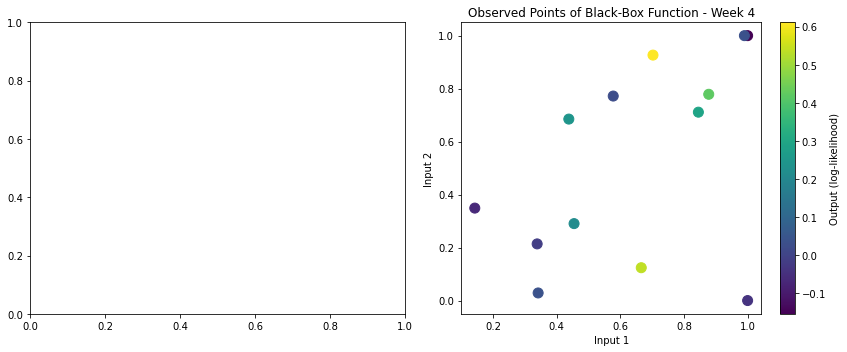

In [11]:
X_wk4 = inputdata_week4
y_wk4 = outputdata_week4

#Comparison between week1 
#plt.figure(figsize=(6,5))
#plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=100)
#plt.colorbar(label='Output (log-likelihood)')
#plt.xlabel('Input 1')
#plt.ylabel('Input 2')
#plt.title('Observed Points of Black-Box Function-Week1')
#plt.show()

#week 2
#plt.figure(figsize=(6,5))
#plt.scatter(X_wk4[:,0], X_wk2[:,1], c=y_wk2, cmap='viridis', s=100)
#plt.colorbar(label='Output (log-likelihood)')
#plt.xlabel('Input 1')
#plt.ylabel('Input 2')
#plt.title('Observed Points of Black-Box Function-Week2')
#plt.show()



fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Week 3 ---
#sc2 = axes[1].scatter(X_wk3[:, 0], X_wk3[:, 1], c=y_wk3, cmap='viridis', s=100)
#axes[1].set_xlabel('Input 1')
#axes[1].set_ylabel('Input 2')
#axes[1].set_title('Observed Points of Black-Box Function - Week 3')
#fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')


#---- Week 4 -----
sc2 = axes[1].scatter(X_wk4[:, 0], X_wk4[:, 1], c=y_wk4, cmap='viridis', s=100)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].set_title('Observed Points of Black-Box Function - Week 4')
fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')

plt.tight_layout()
plt.show()

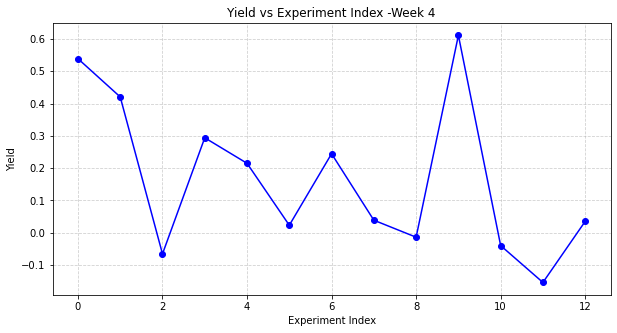

Best parameters: [0.70263656 0.9265642 ]
Best yield: 0.6112052157614438


In [12]:
indices = np.arange(len(outputdata_week4))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week4, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 4')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week4)
best_x = inputdata_week4[best_idx]
best_y = outputdata_week4[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Step 1: Update GP function

In [14]:
kernel = Matern(length_scale=0.3, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk4, y_wk4)

GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=0.3, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

In [15]:
# Find candidate grid 
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])


### Step 2: Fit acquisition function

In [17]:
mu, sigma = gp.predict(X_candidates, return_std=True)

# -------------------------------
# Compute Expected Improvement (EI)
# -------------------------------
y_max = y_wk4.max()
sigma_nonzero = sigma.copy()
sigma_nonzero[sigma_nonzero == 0.0] = 1e-12  # avoid divide by zero
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0.0] = 0.0

In [19]:
# Next best point
x_next = X_candidates[np.argmax(EI)]
print("Next BO point to evaluate:", np.round(x_next,6))


Next BO point to evaluate: [0.878788 0.777778]


# **** Week 5 : Updated data *******

## Step 1: Update the data 

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week5 = inputs_week5[1]
F1_outputs_week5 = outputs_week5[1]


# Step 5: merge with previous data
F1_inputs_week5 = F1_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F1_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F1_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

# Save the results of these
np.save('inputs_week5.npy',inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]
 [1.         1.        ]
 [0.989899   1.        ]
 [0.878788   0.777778  ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849 -0.1539788
  0.03526484  0.342233  ]


## Step 2: Visualise output from previous week

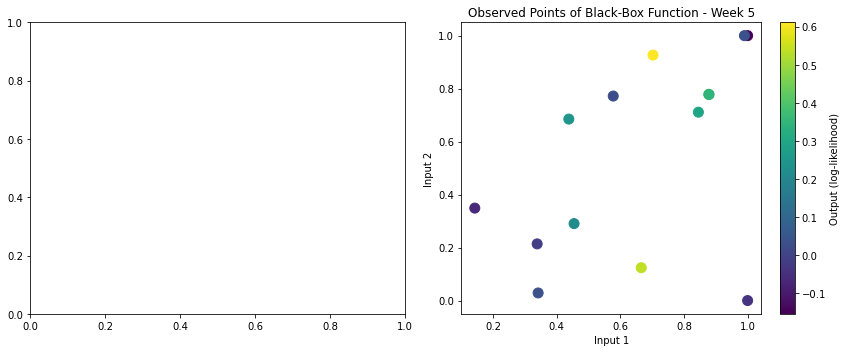

In [9]:
X_wk5 = inputdata_week5
y_wk5 = outputdata_week5

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc2 = axes[1].scatter(X_wk5[:, 0], X_wk5[:, 1], c=y_wk5, cmap='viridis', s=100)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].set_title('Observed Points of Black-Box Function - Week 5')
fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')

plt.tight_layout()
plt.show()


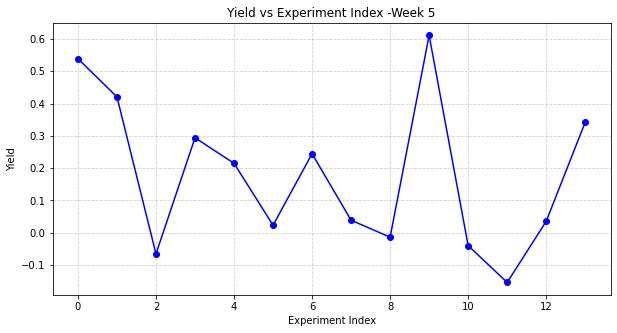

Best parameters: [0.70263656 0.9265642 ]
Best yield: 0.6112052157614438


In [10]:
indices = np.arange(len(outputdata_week5))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week5, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 5')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week5)
best_x = inputdata_week5[best_idx]
best_y = outputdata_week5[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Update gaussian process

In [11]:
kernel = Matern(length_scale=0.3, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk5, y_wk5)

GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=0.3, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

In [12]:
# Find candidate grid 
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])



### Step 4: Fit acquisition function

In [13]:
mu, sigma = gp.predict(X_candidates, return_std=True)

# -------------------------------
# Compute Expected Improvement (EI)
# -------------------------------
y_max = y_wk5.max()
sigma_nonzero = sigma.copy()
sigma_nonzero[sigma_nonzero == 0.0] = 1e-12  # avoid divide by zero
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0.0] = 0.0

In [14]:
# Next best point
x_next = X_candidates[np.argmax(EI)]
print("Next BO point to evaluate:", np.round(x_next,6))

Next BO point to evaluate: [0.707071 0.929293]


# **** Week 6 update *****

## Step 1: Load in updated data

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week6 = inputs_week6[1]
F1_outputs_week6 = outputs_week6[1]


# Step 5: merge with previous data
F1_inputs_week6 = F1_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F1_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F1_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

# Save the results of these
np.save('inputs_week6.npy',inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]
 [1.         1.        ]
 [0.989899   1.        ]
 [0.878788   0.777778  ]
 [0.707071   0.929293  ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849 -0.1539788
  0.03526484  0.342233    0.65875816]


## Step 2: Plot outputs

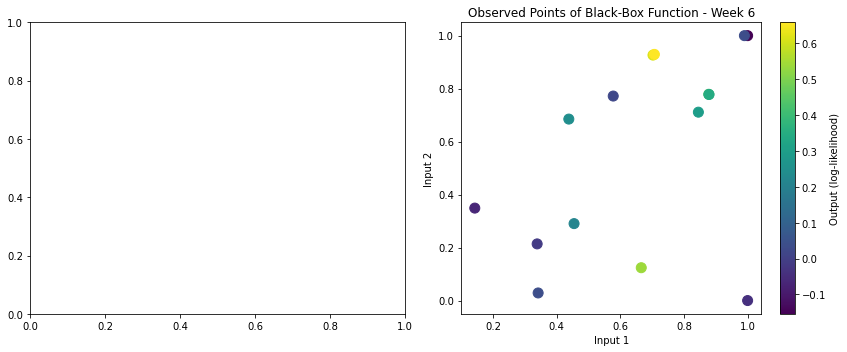

In [3]:
X_wk6 = inputdata_week6
y_wk6 = outputdata_week6

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc2 = axes[1].scatter(X_wk6[:, 0], X_wk6[:, 1], c=y_wk6, cmap='viridis', s=100)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].set_title('Observed Points of Black-Box Function - Week 6')
fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')

plt.tight_layout()
plt.show()



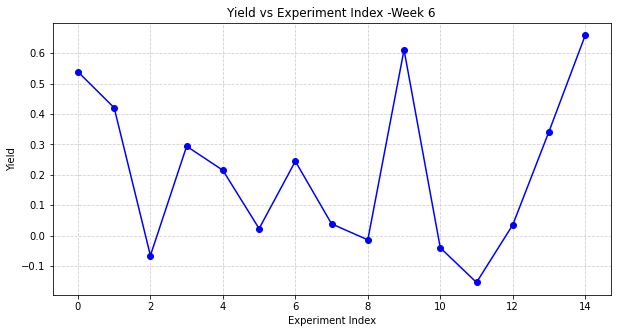

Best parameters: [0.707071 0.929293]
Best yield: 0.6587581588455967


In [4]:
indices = np.arange(len(outputdata_week6))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week6, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 6')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week6)
best_x = inputdata_week6[best_idx]
best_y = outputdata_week6[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: We can see we are improving - so now keep focusing on exploiting this with GP

In [6]:
kernel = Matern(length_scale=0.3, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk6, y_wk6)

GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=0.3, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

## Step 4: Exploitation with acquisition function

In [8]:
### Fit candidate grid# Find candidate grid 
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])


mu, sigma = gp.predict(X_candidates, return_std=True)

# -------------------------------
# Compute Expected Improvement (EI)
# -------------------------------
y_max = y_wk6.max()
sigma_nonzero = sigma.copy()
sigma_nonzero[sigma_nonzero == 0.0] = 1e-12  # avoid divide by zero
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0.0] = 0.0

## Step 5: Find next candidate points

In [9]:
# Next best point
x_next = X_candidates[np.argmax(EI)]
print("Next BO point to evaluate:", np.round(x_next,6))

Next BO point to evaluate: [0.707071 0.939394]


# ****** Week 7 update ********

## Step 1: Update data

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week7 = inputs_week7[1]
F1_outputs_week7 = outputs_week7[1]


# Step 5: merge with previous data
F1_inputs_week7 = F1_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F1_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F1_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

# Save the results of these
np.save('inputs_week7.npy',inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [1.         0.        ]
 [1.         1.        ]
 [0.989899   1.        ]
 [0.878788   0.777778  ]
 [0.707071   0.929293  ]
 [0.707071   0.939394  ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522 -0.03986849 -0.1539788
  0.03526484  0.342233    0.65875816  0.64408605]


## Step 2: Visualise results

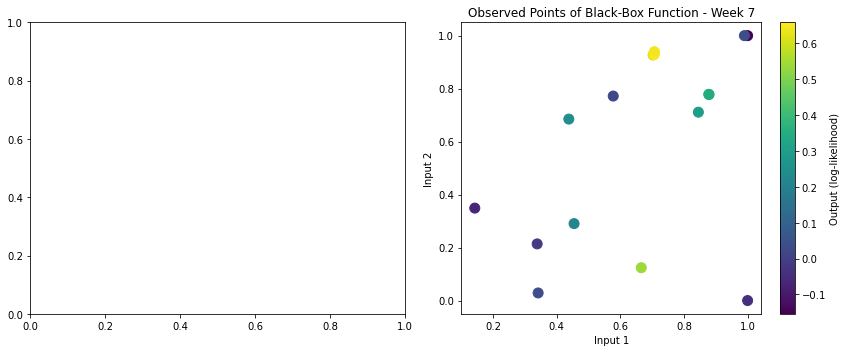

In [5]:
X_wk7 = inputdata_week7
y_wk7 = outputdata_week7

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc2 = axes[1].scatter(X_wk7[:, 0], X_wk7[:, 1], c=y_wk7, cmap='viridis', s=100)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].set_title('Observed Points of Black-Box Function - Week 7')
fig.colorbar(sc2, ax=axes[1], label='Output (log-likelihood)')

plt.tight_layout()
plt.show()

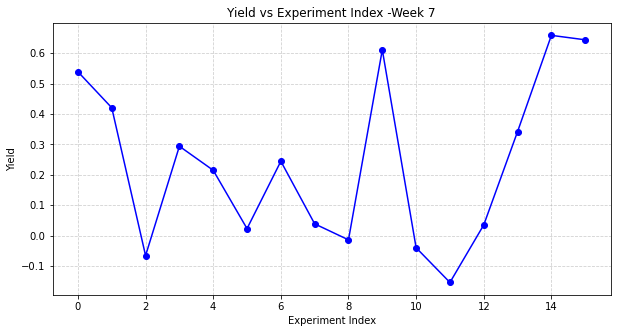

Best parameters: [0.707071 0.929293]
Best yield: 0.6587581588455967


In [7]:
indices = np.arange(len(outputdata_week7))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week7, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 7')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week7)
best_x = inputdata_week7[best_idx]
best_y = outputdata_week7[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Improvements to consider this week

### Point 1: The GP kernel may be too smooth for this landscape. The smoothness does not represent what we see in the output, which is that small distances can result in sharp changes. 

### fix 1: make kernel less smooth- this provides better uncertainty away from samples, encourages exploration between peaks and hsould reduce false confidence around local optima


### Point 2: There is a single fixed length scale for the kernel. The issue is that some areas and regions vary smoothly whilst others do not. Having a single global length scale means it will not be able to handle this well. 

### Fix 2: Allow ARD kernel (e.g., seperate length scales per dimension-making the kernel more anisotropic. This ensures that the BO learns whether one dimension is more important than another.

## Step 3: Update GP model with less smooth kernel

In [9]:
# Rougher kernel for multimodal functions (nu=1.5)
# Separate length scales per dimension (ARD)
kernel = Matern(length_scale=[0.2, 0.2], nu=1.5)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-2,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
)

gp.fit(X_wk7, y_wk7)

# Candidate grid

x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])


# GP prediction

mu, sigma = gp.predict(X_candidates, return_std=True)


## Step 4: Update acquisition

In [10]:
y_max = y_wk7.max()
sigma_nonzero = sigma.copy()
sigma_nonzero[sigma_nonzero == 0.0] = 1e-12

z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0.0] = 0.0


# Next best point

x_next = X_candidates[np.argmax(EI)]
print("Next BO point to evaluate:", np.round(x_next,6))

Next BO point to evaluate: [0.727273 0.      ]
